# Майнор по Анализу Данных, Группа ИАД-2
## 02/03/2017 SVM, Kernel Trick, Бустинг

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

## Немного практики

Загрузите [данные](http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv) о лесных пожарах в некоторых областях парка Montesinho в Португалии.

Описание данных следующее:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 

Описание индексов FFMC, DMC, CD, ISI приводится [здесь](http://cwfis.cfs.nrcan.gc.ca/background/summary/fwi)

Ваша задача - по данным признакам 1-12 предсказать признак 13, площадь области, которая подвергнется пожару.

Перед тем как приступать с модели, постройте гистрограмму площади пожара `area`. Что можно сказать о том, как распределены значения? Рассмотрите различные преобразования, например `log(area+1)` или `sqrt(area)` и выберите то, которое будет лучше использовать для предсказания (линейной моделью).

In [8]:
df = pd.read_csv('forestfires.csv')
df.head()
df.shape

(517, 13)

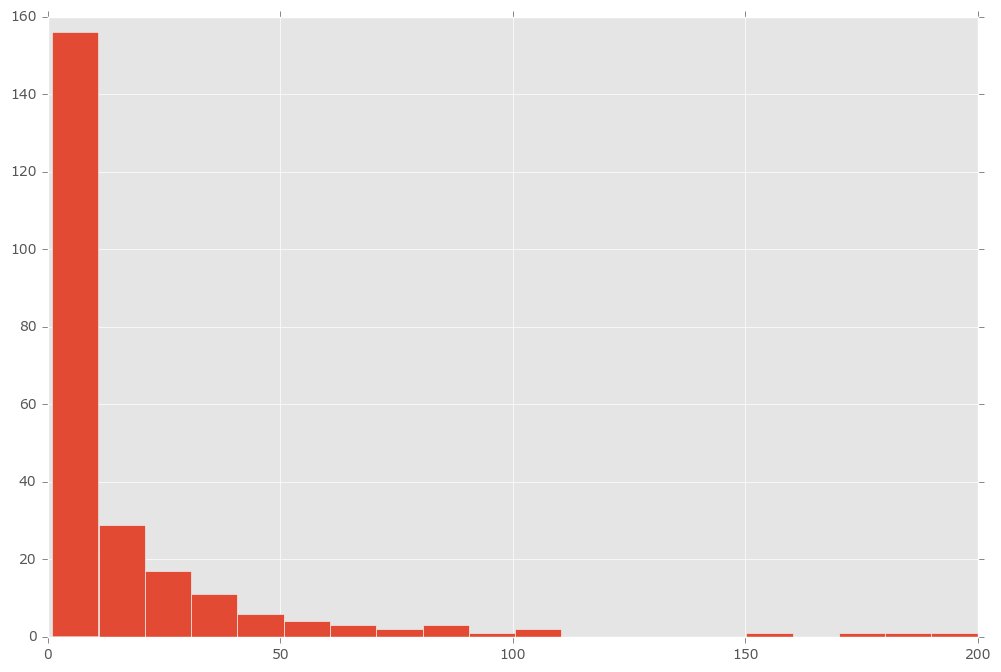

In [32]:
df.area.hist(range=(1,200), bins=20)

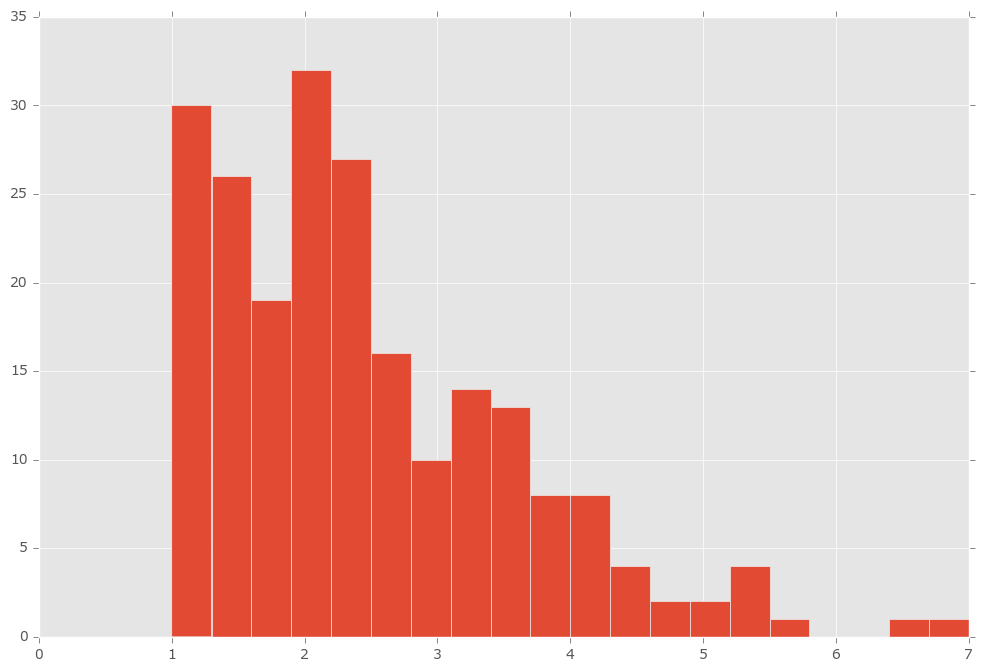

In [31]:
np.log(df.area+1).hist(bins=20, range=(1, 7))

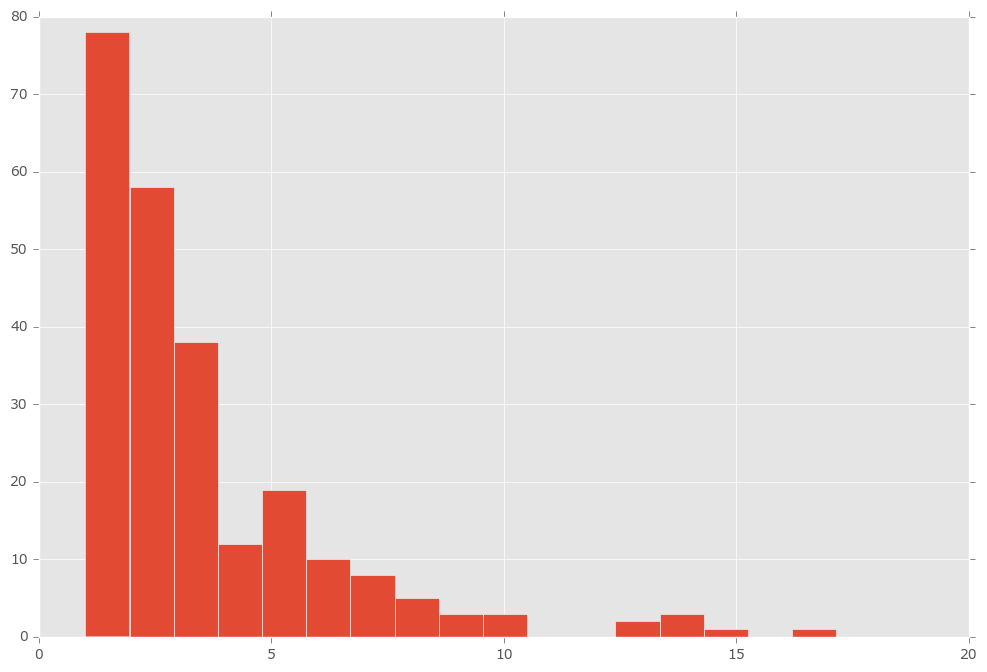

In [33]:
np.sqrt(df.area).hist(bins=20, range=(1, 20))

### Преобразование признаков

Выполните преобразование признаков, а именно:

* Нормализацию вещественных признаков с помощью z-score (x - x.mean())/x.std(). Нормализацию зависимой переменной `area` выполнять не надо **(ПОСЛЕ РАЗБИЕНИЯ НА TRAIN ТЕST) **.
* Преобразование номинальных признаков `month` и `day` в числовое представление.
* Имеет ли смысл преобразование для признаков `X` и `Y`? Если да - выполните его.


На выходе вы должны получить матрицы X_train и X_test с преобразованными признаками, а так же векторы ответов y_train и y_test.

In [26]:
def preproc(df_input):
    df_out = df_input.copy()
    
    df_out.loc[:, 'area'] = df_out.loc[:, 'area'].apply(lambda x: np.log(x + 1))
    
    df_out.loc[:, 'day'] = df_out.replace({'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri':4,
                                           'sat': 5, 'sun':6})
    
    df_out.loc[:, 'month'] = df_out.replace({'jan': 0, 
                                             'feb': 1, 
                                             'mar': 2, 
                                             'apr': 3, 
                                             'may':4,
                                             'jun': 5, 
                                             'jul':6,
                                             'aug':7,
                                             'sep':8,
                                             'oct':9,
                                             'nov':10,
                                             'dec':11})
    
    return df_out

In [27]:
df_preproc = df.pipe(preproc)

In [29]:
df_preproc.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,2,4,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,9,1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,9,5,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,2,4,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,2,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [34]:
# Пробуем узнать с помощью леса, важны ли месяца и дни
X, y = df_preproc.iloc[:, :-1].values, df_preproc.iloc[:, -1]

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
rf = RandomForestRegressor(n_estimators=40)

rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [48]:
f_importance = pd.Series(data=rf.feature_importances_, index=df.columns[:-1])


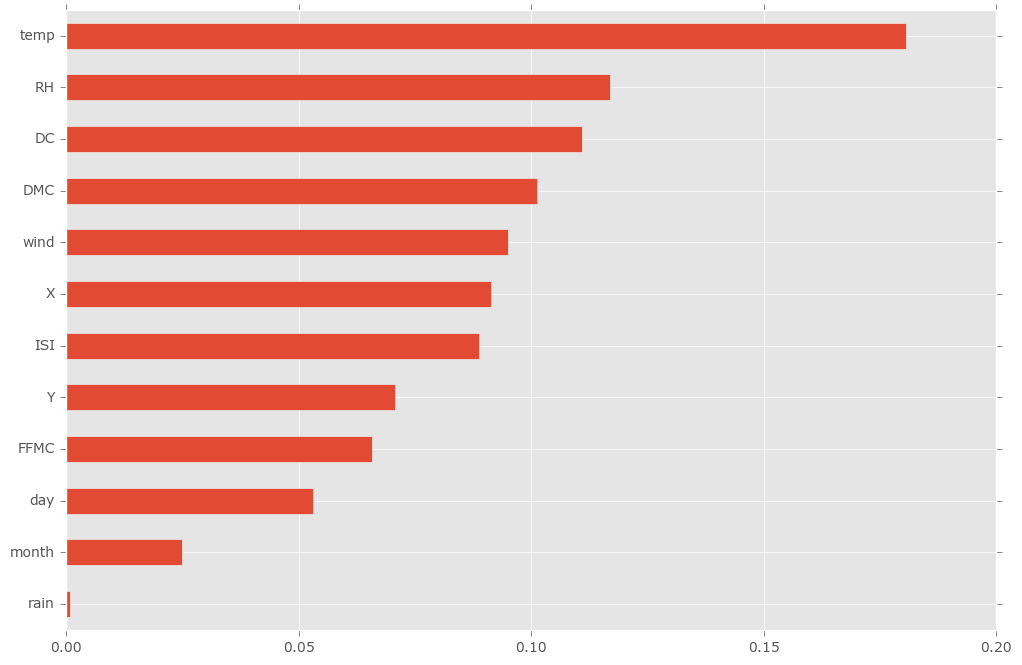

In [49]:
f_importance.sort_values().plot(kind='barh')

### Обучение

Обучите модели:

* Простую линейную регрессию `LinearRegression` (без регуляризации). Выберите такое подмножество признаков из X_train, чтобы избежать мультиколлинеарности.
* SVM без ядра
* SVM с ядром
* Gradient Boosting

Для оценки качества используйте 5-fold CV и меру качества MSE

Расчитайте предсказания для контролькой выборки. 

* Найдите среднюю абсолютную ошибку модели на контрольной выборке
* Постройте график зависимости ошибок $|(\text{area}) - (\text{predicted_area})|$ и значений признака $\text{area}$, где $\text{area}$ и $\text{predicted_area}$ - значения в исходной шкале, а не преобзованной после задания 2.1
* Какие значения модель предсказывает лучше?

In [55]:
import seaborn as sns

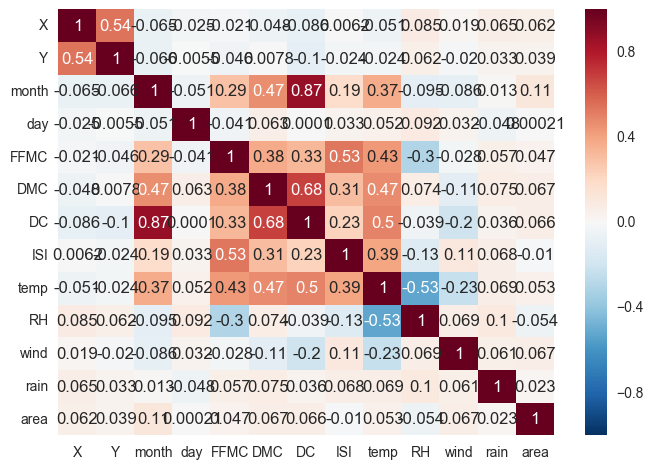

In [58]:
sns.heatmap(df_preproc.corr(), annot=True)

In [60]:
X, y = df_preproc.iloc[:, :-1].values, df_preproc.iloc[:, -1]

In [59]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [80]:
# Оставим нужные колонки
idx_cols = (~df_preproc.columns[:-1].isin(['month', 'DMC', 'X', 'Y', 'day']))

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [69]:
model = Pipeline([('scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())])

In [81]:
model.fit(X_train[:, idx_cols], y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [83]:
y_hat = model.predict(X_test[:, idx_cols])

In [84]:
from sklearn.metrics import mean_absolute_error

In [85]:
mean_absolute_error(y_test, y_hat)

1.0923800862380215

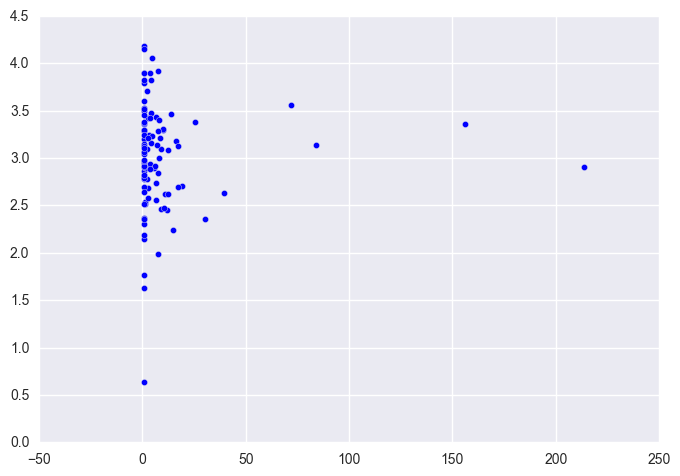

In [86]:
plt.scatter(np.exp(y_test), np.exp(y_hat))

# ML BootCamp

На сайте [ml bootcamp](http://mlbootcamp.ru/championship/10/) выложено соревнование по предсказанию оттока из он-лайн игры. Признаки уже готовы, но они могут содержать выборосы и аномалии.

Функционал качества - [log-loss](https://www.kaggle.com/wiki/LogarithmicLoss)

Давайте попробуем порешать эту задачу

In [3]:
##  Your Code Here